In [53]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


In [54]:
# Импортируем библиотеку pandas
import pandas as pd

# Загружаем набор данных из CSV-файла
data = pd.read_csv('Фразы-эмоции.csv')

# Выполняем первичный анализ данных:
# 1. Выводим информацию о типах данных и пропущенных значениях
print(data.info())

# 2. Отображаем первые пять строк набора данных
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Текст фразы  1043 non-null   object
 1   Эмоция       1043 non-null   object
dtypes: object(2)
memory usage: 16.4+ KB
None
                                         Текст фразы        Эмоция
0  Я не могу поверить, что ты снова опоздал на ва...  Недовольство
1  Врач, к которому меня направили, оказался груб...  Недовольство
2  Как же меня раздражает твоя привычка постоянно...  Недовольство
3  Мне кажется, что некоторые врачи просто зараба...  Недовольство
4  Мне надоело слушать твои бесконечные жалобы и ...  Недовольство


In [55]:
# Вывод уникальных классов
print("Уникальные классы в данных:")
print(data['Эмоция'].unique())

Уникальные классы в данных:
['Недовольство' 'Злость' 'Зависть' 'Сочувствие' 'Радость' 'Печаль'
 'Интерес' 'Нейтрально']


In [56]:
# Извлекаем столбцы из набора данных
texts = data['Текст фразы']  # Столбец с текстами фраз
labels = data['Эмоция']      # Столбец с эмоциями


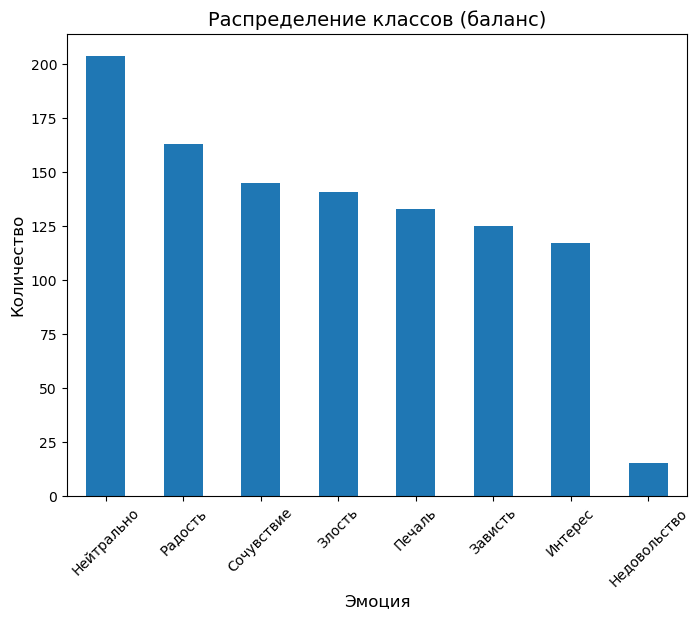

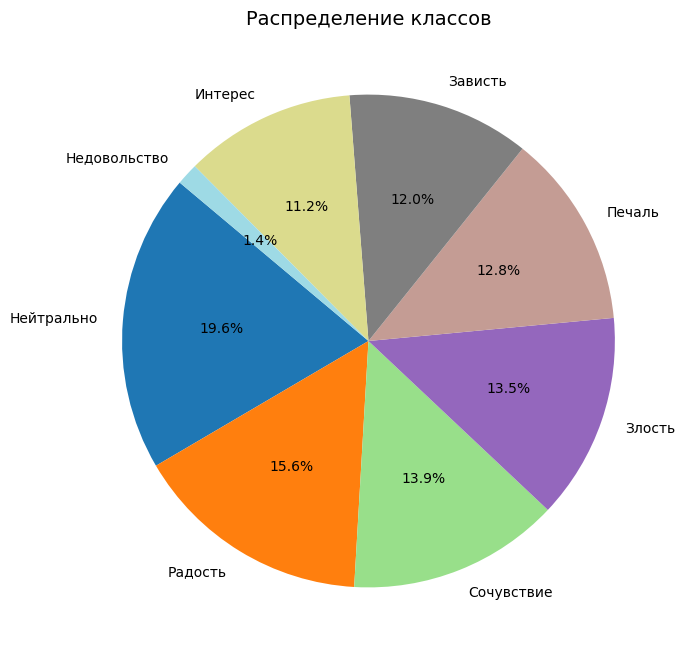

In [57]:
# Анализ баланса классов
class_counts = labels.value_counts()  # Подсчитываем количество объектов для каждого класса

# Построение гистограммы распределения классов
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
class_counts.plot(kind='bar')  # Построение столбчатой диаграммы
plt.title('Распределение классов (баланс)', fontsize=14)  # Заголовок
plt.xlabel('Эмоция', fontsize=12)  # Подпись оси X
plt.ylabel('Количество', fontsize=12)  # Подпись оси Y
plt.xticks(rotation=45)  # Угол наклона подписей на оси X
plt.show()  # Отображаем график

# Построение круговой диаграммы распределения классов
plt.figure(figsize=(8, 8))  # Устанавливаем размер графика
class_counts.plot(
    kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20'
)  # Построение круговой диаграммы
plt.title('Распределение классов', fontsize=14)  # Заголовок
plt.ylabel('')  # Убираем подпись оси Y для улучшения визуализации
plt.show()  # Отображаем график


In [58]:
# Импортируем модуль nltk и загружаем стандартные стоп-слова для русского языка
from nltk.corpus import stopwords

# Получаем стандартный список стоп-слов для русского языка
russian_stopwords = stopwords.words('russian')

# Дополняем список пользовательскими стоп-словами
additional_stopwords = ['это', 'всё', 'просто', 'очень']  # Определяем дополнительные стоп-слова
russian_stopwords.extend(additional_stopwords)  # Расширяем стандартный список


Распределение длины текстов:
count    1043.000000
mean       93.270374
std        39.179906
min        24.000000
25%        63.000000
50%        88.000000
75%       120.000000
max       346.000000
Name: Text_Length, dtype: float64


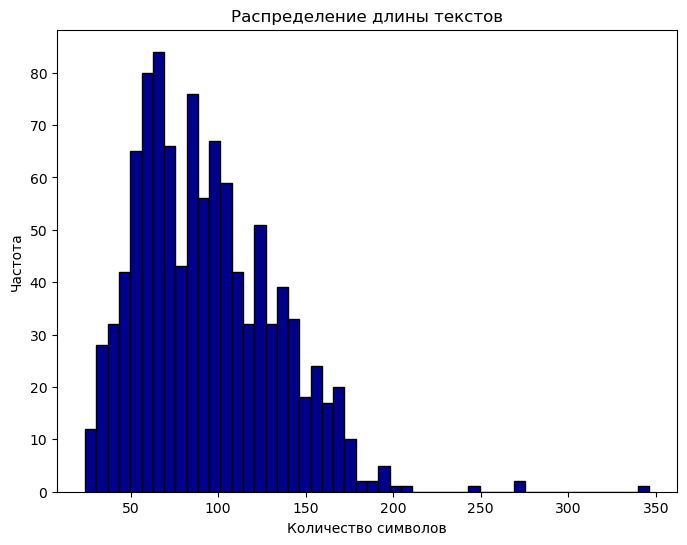

In [59]:
# Добавляем столбец с длиной текста
data['Text_Length'] = data['Текст фразы'].astype(str).apply(len)

# Описание распределения длины текстов
text_length_distribution = data['Text_Length'].describe()
print('Распределение длины текстов:')
print(text_length_distribution)

# Визуализация распределения длины текстов
plt.figure(figsize=(8, 6))
plt.hist(data['Text_Length'], bins=50, color='darkblue', edgecolor='black')
plt.title('Распределение длины текстов')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.show()

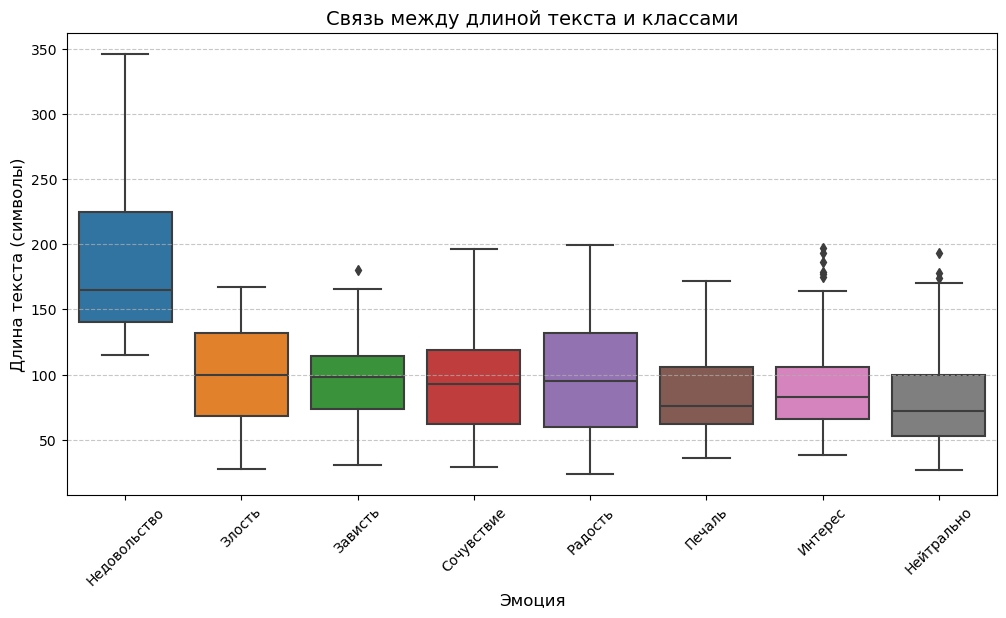

In [60]:
# Рассчитываем среднюю длину текста для каждого класса
class_length_stats = data.groupby('Эмоция')['Text_Length'].describe()

# Визуализируем связь между длиной текста и классами
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
sns.boxplot(x='Эмоция', y='Text_Length', data=data)  # Построение коробчатой диаграммы
plt.title('Связь между длиной текста и классами', fontsize=14)  # Заголовок
plt.xlabel('Эмоция', fontsize=12)  # Подпись оси X
plt.ylabel('Длина текста (символы)', fontsize=12)  # Подпись оси Y
plt.xticks(rotation=45)  # Поворот подписей на оси X для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку для лучшей читаемости
plt.show()  # Отображаем график


In [61]:
# Функция для предобработки текста с удалением стоп-слов
def preprocess_text_with_stopwords_removal(text):
    """
    Выполняет предобработку текста:
    1. Приводит текст к нижнему регистру.
    2. Удаляет стоп-слова.

    Параметры:
        text (str): Исходный текст.

    Возвращает:
        str: Предобработанный текст.
    """
    # Приведение текста к нижнему регистру
    text = text.lower()
    
    # Удаление стоп-слов
    text = ' '.join(
        [word for word in text.split() if word not in russian_stopwords]
    )
    
    return text

# Применение функции предобработки к данным
data['Текст фразы'] = data['Текст фразы'].apply(preprocess_text_with_stopwords_removal)

# Просмотр первых пяти строк предобработанного текста
print(data['Текст фразы'].head())


0    могу поверить, снова опоздал важную встречу, н...
1    врач, которому направили, оказался грубым невн...
2    раздражает твоя привычка постоянно перебивать ...
3    кажется, некоторые врачи зарабатывают деньги п...
4    надоело слушать твои бесконечные жалобы нытьё,...
Name: Текст фразы, dtype: object


In [62]:
# Функция для получения частотности слов по классу
def get_word_frequencies(data, emotion_label, num_words=10):
    """
    Возвращает топ-слова и их частотность для заданного класса.

    Параметры:
        data (pd.DataFrame): Набор данных.
        emotion_label (str): Название класса (эмоции).
        num_words (int): Количество топ-слов для возврата.

    Возвращает:
        list: Список кортежей (слово, частота).
    """
    # Фильтруем данные по заданному классу
    emotion_data = data[data['Эмоция'] == emotion_label]
    
    # Создаем объект CountVectorizer с учетом стоп-слов
    vectorizer = CountVectorizer(stop_words=russian_stopwords)
    
    # Преобразуем текстовые данные в матрицу частотности
    word_counts = vectorizer.fit_transform(emotion_data['Текст фразы'].dropna())
    
    # Суммируем частоты слов по всем текстам
    word_sums = word_counts.sum(axis=0)
    
    # Извлекаем слова и их частоты
    word_freq = [
        (word, word_sums[0, idx])
        for word, idx in vectorizer.vocabulary_.items()
    ]
    
    # Сортируем слова по убыванию частоты и берем только топ-слова
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:num_words]
    
    return word_freq

# Получаем частотность слов для каждого класса эмоций
classes = data['Эмоция'].unique()  # Уникальные значения классов
for emotion_label in classes:
    # Получаем топ-слова для текущего класса
    words = get_word_frequencies(data, emotion_label)
    
    # Выводим результат
    print(f'Часто встречающиеся слова для класса "{emotion_label}": {words}')



Часто встречающиеся слова для класса "Недовольство": [('мной', 5), ('жалобы', 4), ('могу', 3), ('твои', 3), ('врач', 3), ('которому', 2), ('направили', 2), ('оказался', 2), ('грубым', 2), ('невнимательным', 2)]
Часто встречающиеся слова для класса "Злость": [('почему', 25), ('сколько', 14), ('могу', 14), ('время', 12), ('каждый', 11), ('снова', 11), ('терпеть', 11), ('одно', 9), ('нужно', 9), ('вообще', 9)]
Часто встречающиеся слова для класса "Зависть": [('тебе', 26), ('повезло', 18), ('снова', 16), ('удаётся', 13), ('время', 13), ('быстро', 12), ('легко', 12), ('могу', 11), ('такие', 11), ('отпуск', 11)]
Часто встречающиеся слова для класса "Сочувствие": [('жаль', 30), ('понимаю', 29), ('тебе', 25), ('тяжело', 17), ('сочувствую', 15), ('помочь', 15), ('ужасно', 13), ('наверное', 12), ('действительно', 11), ('неприятно', 11)]
Часто встречающиеся слова для класса "Радость": [('сегодня', 29), ('могу', 17), ('день', 17), ('здорово', 13), ('рада', 11), ('спасибо', 11), ('приятно', 10), ('

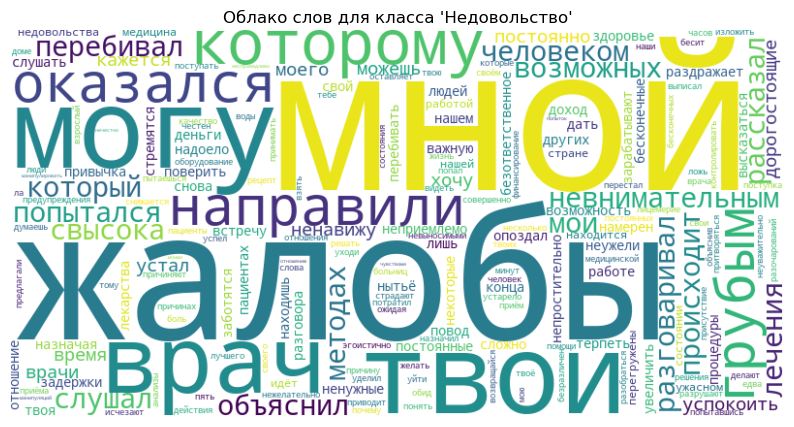

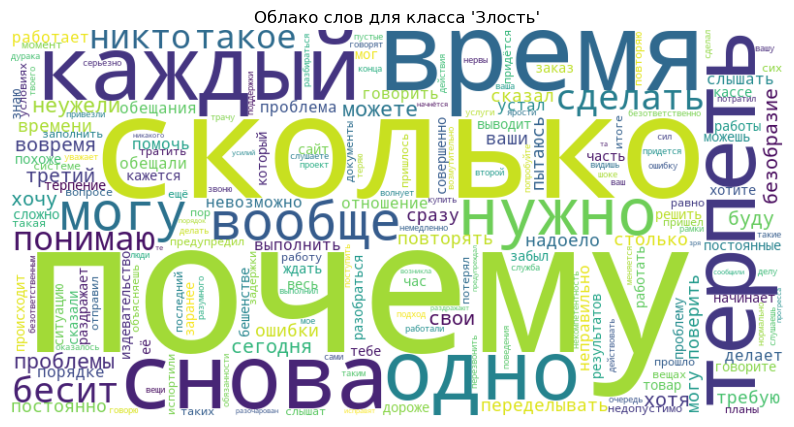

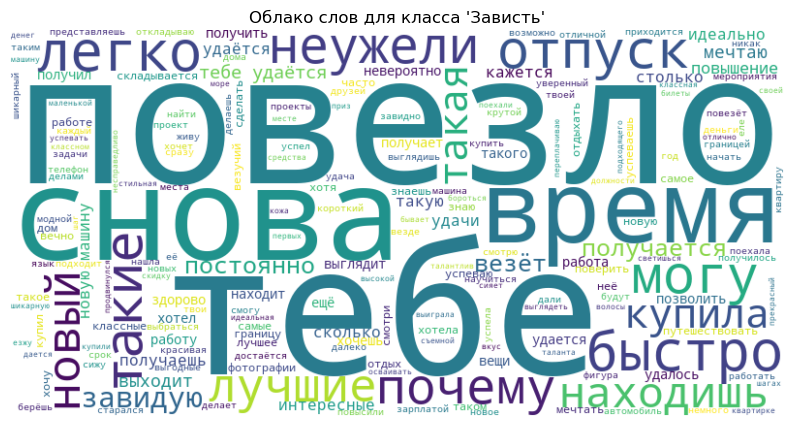

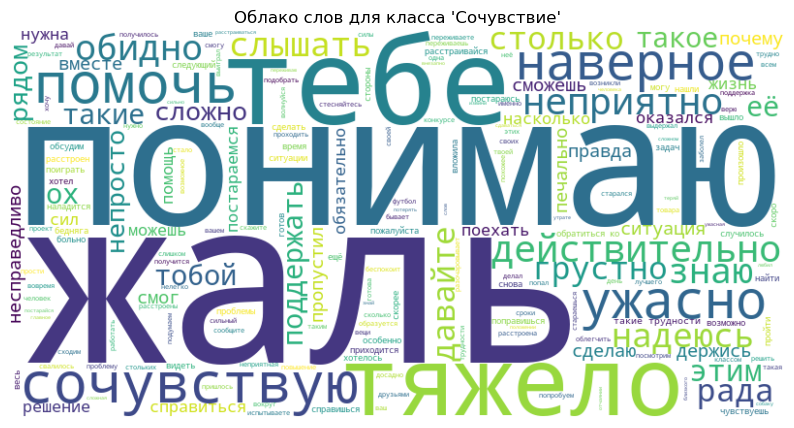

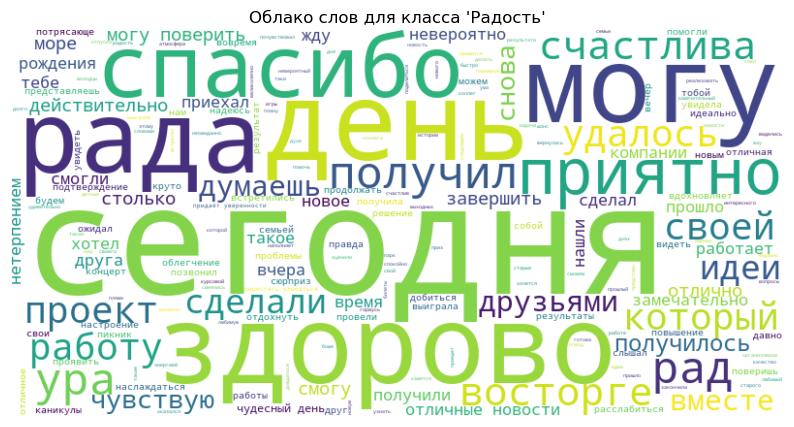

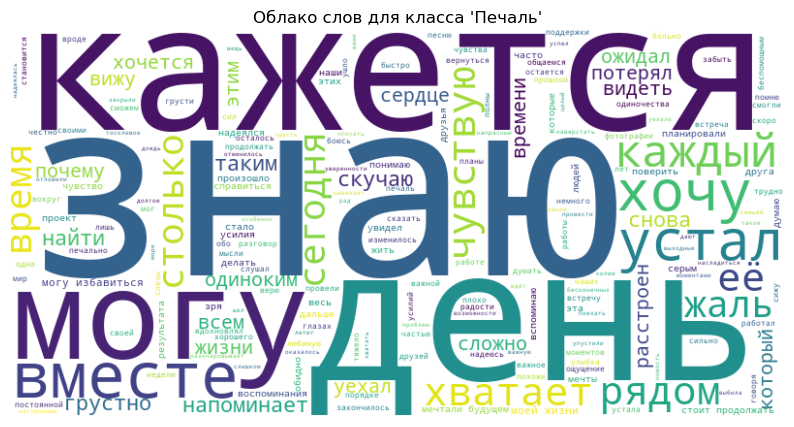

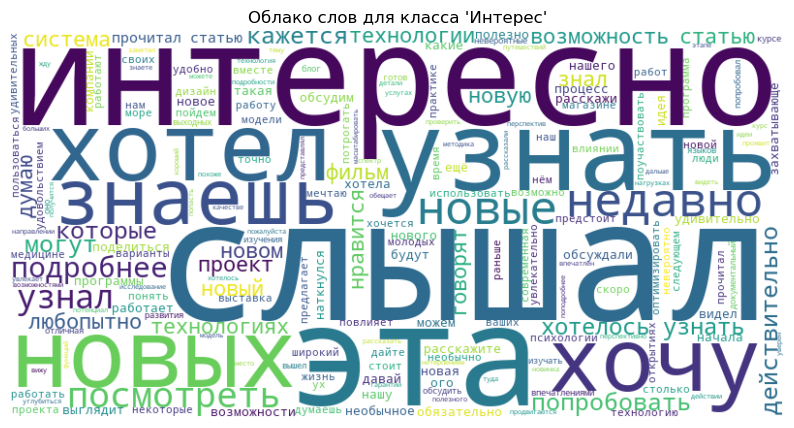

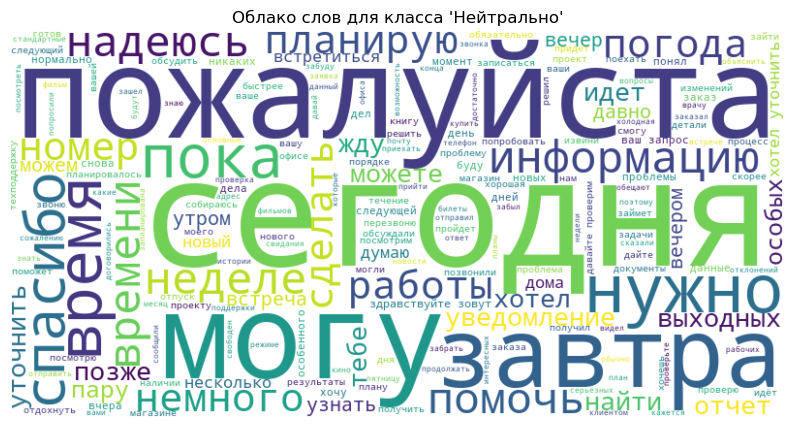

In [63]:
# Функция для отображения облака слов
def plot_wordcloud(text_data, title, stop_words):
    """
    Отображает облако слов для заданного текста.

    Параметры:
        text_data (iterable): Коллекция текстовых данных.
        title (str): Заголовок графика.
        stop_words (list): Список стоп-слов для исключения из облака.
    """
    # Объединяем тексты в одну строку
    text = ' '.join(text_data)
    
    # Создаем объект WordCloud с заданными параметрами
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stop_words
    ).generate(text)
    
    # Настраиваем и отображаем график
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Отключаем оси для визуализации
    plt.title(title)
    plt.show()

# Облако слов для каждого класса эмоций
for emotion_label in classes:
    # Получаем текстовые данные для текущего класса
    text_data = data[data['Эмоция'] == emotion_label]['Текст фразы'].dropna().astype(str)
    
    # Отображаем облако слов с использованием корректного списка стоп-слов
    plot_wordcloud(text_data, f"Облако слов для класса '{emotion_label}'", russian_stopwords)


### Обобщающее заключение по EDA

### **. Общая структура и баланс классов**
- **классы:** В датасете представлено 8 категорий: "Недовольство", "Злость", "Зависть", "Сочувствие", "Радость", "Печаль", "Интерес" и "Нейтрально".
- **Дисбаланс классов:** Наиболее распространенным классом является "Нейтрально" (около 19.6%), а наименее представленным — "Недовольство" (1.4%). Это требует учета при разработке моделей, чтобы избежать доминирования классов с большим числом примеров.

---

### **2. Лексическая специфика классов**
- В каждом классе наблюдается **уникальный набор часто встречающихся слов**, отражающих характерные эмоции. Например:
  - "Недовольство": **"жалобы", "грубым", "невнимательным"** — акцент на негативный опыт и критику.
  - "Злость": **"почему", "терпеть", "снова"** — выражение раздражения и повторяющихся проблем.
  - "Зависть": **"повезло", "тебе", "легко"** — сравнение себя с другими и выражение зависти.
  - "Сочувствие": **"жаль", "понимаю", "помочь"** — акцент на эмпатии и поддержке.
  - "Радость": **"сегодня", "здорово", "спасибо"** — позитивные события и благодарность.
  - "Печаль": **"грустно", "устал", "кажется"** — фокус на усталости и разочаровании.
  - "Интерес": **"интересно", "узнать", "новых"** — выражение любопытства и поиска знаний.
  - "Нейтрально": **"сегодня", "нужно", "пожалуйста"** — повседневные темы и уточнения.

---

### **3. Длина текстов**
- **Средняя длина текста:** 93 символа, с медианой в 88 символов. Большинство текстов содержат от 50 до 150 символов.
- Класс "Недовольство" выделяется более длинными текстами, что может свидетельствовать о необходимости более развернутого описания негативного опыта.
- Другие классы (например, "Злость", "Зависть") характеризуются более короткими текстами, что указывает на лаконичное выражение эмоций.

---

### **4.Облако слов**
Облака слов подтвердили характерную лексическую специфику каждого класса:
- Например, в классе "Сочувствие" преобладают слова поддержки и эмпатии, такие как **"жаль", "понимаю"**, а в классе "Радость" — позитивные слова, такие как **"здорово", "рада"**.

---
